<h2>Imports</h2>

In [1]:
import math
import random
import os
from common.multiprocessing_env import SubprocVecEnv
from ppo import *
import datetime
import fnmatch

import gym
import my_envs
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

np.random.seed(0)
torch.manual_seed(2)

%matplotlib inline

# Load baseline policies
Load trained baseline policies on individually modified environments for testing on multi-modified environment
### Environments:

#### InvertedPendulum-v2 environment:  
<img src="./notebookImages/invertedpendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="./notebookImages/halfcheetah.png" width="300">

#### Ant environment:
<img src="./notebookImages/ant.png" width="300">

<h2>Use CUDA</h2>

In [2]:
use_cuda = torch.cuda.is_available()
#use_cuda = False
device   = torch.device("cuda" if use_cuda else "cpu")

## Helper Functions

In [3]:
def make_env(env_name):
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

In [4]:
class baseline_ensemble():
    def __init__(self, base_env_name, import_tags, num_inputs, num_outputs, debug = False):
        self.base_env_name = base_env_name
        self.import_tags = import_tags
        self.import_folders = {} 
        self.policies = {}
        self.policy_list = []
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.debug = debug
        
    def import_policies(self):
        folder_names = os.listdir('./baseline_weights')
        for mod in self.import_tags:
            self.import_folders[mod] = fnmatch.filter(folder_names, self.base_env_name + mod + '*')
        
        for key, val in self.import_folders.items():
            folder = os.listdir('./baseline_weights/' + str(val[0]))
            
            if self.debug:
                print("weight folder:     ", folder)
            
            weight_file = fnmatch.filter(folder, '*endweights')
            weight_file = weight_file[0]
            
            if self.debug:
                print("Weight file:     ", weight_file)
            
            self.policies[key] = PPO(self.num_inputs, self.num_outputs)
            full_weight_file = './baseline_weights/' + str(val[0]) + '/' + weight_file
            self.policies[key].load_weights(full_weight_file)
            
        if self.debug:
            print("Imported Policies:\n")
            for mod, policy in self.policies.items():
                print("Modification:    ", mod)
                print(policy.model)
                
        self.policy_list = self.policies.values()
        
    def uniform_action(self, state):
        """ Outputs a uniform average of actions from variable number of policies"""
        num_policies = len(self.policy_list)
        actions = np.array([policy.model.sample_action(state) for policy in self.policy_list])

        action = action.sum()/num_policies
        return action

    def weighted_action(self, state, policy_weights):
        """ Outputs a weighted sum of actions defined by weight vector and variable number of policies"""
        if policy_weights.shape[1] != len(self.policy_list):
            print("Weight vector length must match number of policies\n")
            print("weights:    ", policy_weights)
            print("length ", policy_weights.shape[1])
            print("policy list:    ", self.policy_list)
            print("length: ", len(self.policy_list))
            return 
        
        if self.debug:
            print("weights:    ", policy_weights)
            print("length ", policy_weights.shape[1])
            print("policy list:    ", self.policy_list)
            print("length: ", len(self.policy_list))

        for i, policy in enumerate(self.policy_list):
            if i == 0:
                actions = policy.model.sample_action(state)
            else:
                actions = torch.cat((actions, policy.model.sample_action(state)), 2)
            
        actions = actions.squeeze(0)
        weights = policy_weights

        if self.debug:
            print("multi-policy multi-env action tensor: ")
            print(actions, actions.size())
            print("ensemble weights:")
            print(weights, weights.size())
        
        action = torch.sum((actions * weights), dim=1).unsqueeze(1)
        if self.debug:
            print("action:")
            print(action, action.size())
        return action
    
    
class PPO_Ensemble(PPO):
    def __init__(self, num_inputs, num_outputs, ensemble, hidden_size=64, lr = 3e-4, num_steps = 2048,
                 mini_batch_size = 64, ppo_epochs = 10, threshold_reward = 950):
        super().__init__(num_inputs, num_outputs, hidden_size=64, lr = 3e-4, num_steps = 2048,
                 mini_batch_size = 64, ppo_epochs = 10, threshold_reward = 950)
        self.ensemble = ensemble
        
    def collect_data(self, envs):
        if self.state is None:
            state = envs.reset()
            
        #----------------------------------
        #collect data
        #----------------------------------
        log_probs = []
        values    = []
        states    = []
        actions   = []
        rewards   = []
        masks     = []
        entropy = 0
        counter = 0

        for _ in range(self.num_steps):
            state = torch.FloatTensor(state).to(device)
            dist, value = self.model(state)

            weights = dist.sample()
            action = self.ensemble.weighted_action(state.cpu().numpy(), weights)
            next_state, reward, done, _ = envs.step(action.cpu().numpy())
#             next_state, reward, done, _ = envs.step(action)
            
            log_prob = dist.log_prob(weights)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

            states.append(state)
            actions.append(weights)

            state = next_state
            self.frame_idx += 1


        next_state = torch.FloatTensor(next_state).to(device)
        _, next_value = self.model(next_state)

        return log_probs, values, states, actions, rewards, masks, next_value
        
class ensemble_testing_envs(testing_envs):
    def __init__(self, env_names, VISUALIZE, COMPENSATION, results_dir, train_env_index, logging_interval = 10):
        super().__init__(env_names, VISUALIZE, COMPENSATION, results_dir, train_env_index, logging_interval = 10)
        
    def test_env(self, env, ensemble_net, weight_net, comp_model = None):
        
        def test_action(state):
            dist, value = weight_net.model(state)
            weights = dist.sample()
            action = ensemble_net.weighted_action(state.cpu().numpy(), weights)
            return action
        
        state = env.reset()
        if self.vis: 
            env.render()
        done = False
        total_reward = 0
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            sample = test_action(state)
            
            #state = torch.FloatTensor(state).unsqueeze(0).to(device)
            #dist, _ = control_model(state)
            #sample = dist.sample().cpu().numpy()[0]
                            
            next_state, reward, done, _ = env.step(sample.cpu().numpy())
            state = next_state
            if self.vis:
                env.render()
            total_reward += reward
        return total_reward
        

<h2>Create Environments and Import Baseline Policies</h2>

In [5]:
from gym import envs

VISUALIZE = False
COMPENSATION = False
EARLY_STOPPING = True
logging_interval = 10
num_envs = 4
env_key = "multi-v10" #Unique identifier for custom envs (case sensitive)

env_name = 'InvertedPendulumModified-multi-v10'

env_ids = [spec.id for spec in envs.registry.all()]
test_env_names = [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier
test_env_idx = 0

template_env_name = 'InvertedPendulum-v2'
template_env = gym.make(template_env_name)

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

#Plotting Results and figures, save weights
script_dir = os.getcwd()
time_stamp = datetime.datetime.now().replace(microsecond=0).isoformat()
results_dir = os.path.join(script_dir, 'weighted_baseline_results/' + 'TEST'+ env_name + time_stamp + '/')
baseline_dir = os.path.join(script_dir, 'weighted_baseline_weights/' + 'TEST' + env_name + time_stamp + '/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(baseline_dir):
    os.mkdir(baseline_dir)
    
tests = ensemble_testing_envs(test_env_names, VISUALIZE, COMPENSATION, results_dir, test_env_idx)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

Process Process-4:
Process Process-1:
Process Process-3:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process

## Training baseline PPO controller

In [6]:
base_inputs  = template_env.observation_space.shape[0]
base_outputs = template_env.action_space.shape[0]

tags = ['friction', 'inertia', 'mass', 'motor', 'tilt']
base_name = 'InvertedPendulumModified-'

ensemble = baseline_ensemble(base_env_name=base_name, 
                              import_tags=tags, 
                              num_inputs=base_inputs, 
                              num_outputs=base_outputs, 
                              debug=False)


ensemble.import_policies()

In [7]:
num_inputs = template_env.observation_space.shape[0]
num_outputs = len(ensemble.policy_list)

#Hyper params:
hidden_size      = 64
lr               = 3e-4
num_steps        = 2048
mini_batch_size  = 64
ppo_epochs       = 10
threshold_reward = 900

baseline_weighting = PPO_Ensemble(num_inputs, num_outputs, ensemble)
print(baseline_weighting.model)

ActorCritic(
  (critic): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [8]:
max_frames = 1000000
frame_idx  = 0
test_avg_rewards = []
test_stds = []
test_itrs = 20

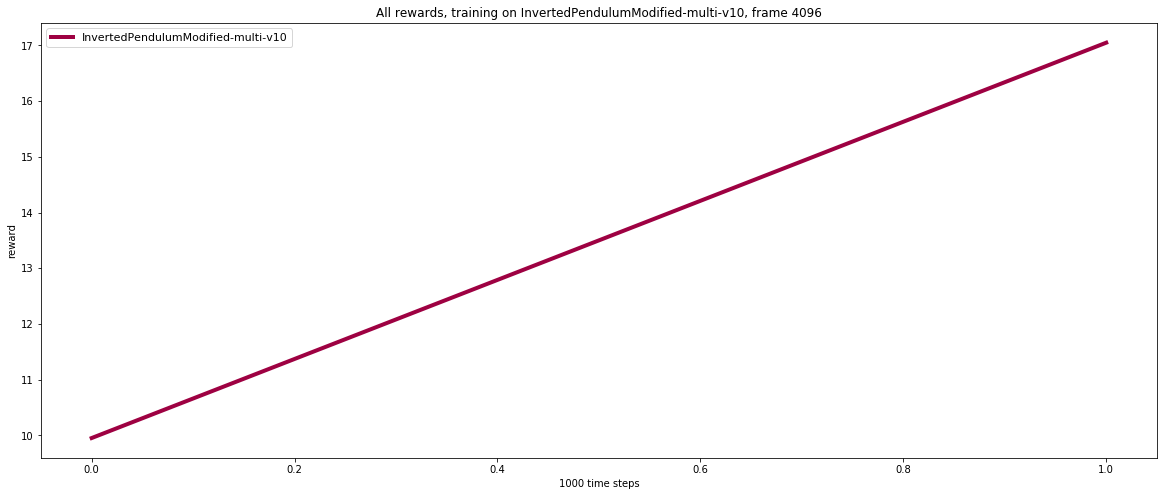

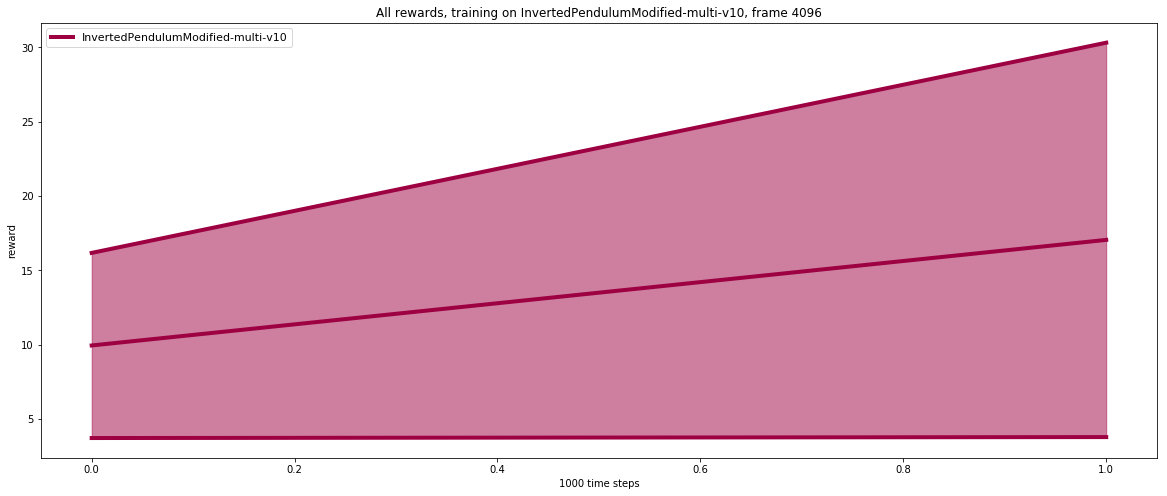

KeyboardInterrupt: 

In [9]:
state = envs.reset()
early_stop = False
ppo_updates = 0
save_interval = 5
#Plotting Flags
indvplots=0
rewplots=1
stdplots=1
which_plts = [indvplots,rewplots,stdplots]

while baseline_weighting.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = baseline_weighting.collect_data(envs)
    
    #compute gae
    returns = baseline_weighting.compute_gae(next_value, rewards, masks, values)
    
    #update policy
    baseline_weighting.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []
    
    #Environment testing and data logging
    #***************************************************************************************
    for env in tests.envs:
        env_rewards = ([tests.test_env(env, ensemble, baseline_weighting) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)

    if avg_rew[test_env_idx] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        tests.plot(baseline_weighting.frame_idx, test_avg_rewards, test_stds, which_plts, 1)
        early_stop = True
    else:
        if ppo_updates and ppo_updates % save_interval == 0:
#             baseline_weighting.save_weights(baseline_dir + env_name + '_weights' + str(ppo_updates/save_interval))
            tests.plot(baseline_weighting.frame_idx, test_avg_rewards, test_stds, which_plts, 1, str(ppo_updates/save_interval))
        else:
            tests.plot(baseline_weighting.frame_idx, test_avg_rewards, test_stds, which_plts, 0)
            
    ppo_updates = ppo_updates + 1 #Loop counter
    #***************************************************************************************

# baseline_weighting.save_weights(baseline_dir + env_name + '_endweights')